In [9]:
#@title Import revelant modules and install Facets
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format


# For facets
from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

In [3]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_csv = tf.keras.utils.get_file('adult.data', 
  'https://download.mlcc.google.com/mledu-datasets/adult_census_train.csv')
test_csv = tf.keras.utils.get_file('adult.data', 
  'https://download.mlcc.google.com/mledu-datasets/adult_census_test.csv')

train_df = pd.read_csv(train_csv, names=COLUMNS, sep=r'\s*,\s*', 
                       engine='python', na_values="?")
test_df = pd.read_csv(test_csv, names=COLUMNS, sep=r'\s*,\s*', skiprows=[0],
                      engine='python', na_values="?")

3981312/3974305 [==============================] - 1s 0us/step


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   gender          32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income_bracket  32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.6,13.6,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.4,105550.0,12285.0,117827.0,178356.0,237051.0,1484705.0
education_num,32561.0,10.1,2.6,1.0,9.0,10.0,12.0,16.0
capital_gain,32561.0,1077.6,7385.3,0.0,0.0,0.0,0.0,99999.0
capital_loss,32561.0,87.3,403.0,0.0,0.0,0.0,0.0,4356.0
hours_per_week,32561.0,40.4,12.3,1.0,40.0,40.0,45.0,99.0


In [10]:
def pandas_to_numpy(data):
    '''Convert a pandas DataFrame into a Numpy array'''
    # Drop empty rows.
    data = data.dropna(how="any", axis=0)

    # Separate DataFrame into two Numpy arrays"
    labels = np.array(data['income_bracket'] == ">50K")
    features = data.drop('income_bracket', axis=1)
    features = {name:np.array(value) for name, value in features.items()}

    return features, labels

In [11]:
# Since we don't know the full range of possible values with occupation and
# native_country, we'll use categorical_column_with_hash_bucket() to help map
# each feature string into an integer ID.
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    "occupation", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    "native_country", hash_bucket_size=1000)

# For the remaining categorical features, since we know what the possible values
# are, we can be more explicit and use categorical_column_with_vocabulary_list()
gender = tf.feature_column.categorical_column_with_vocabulary_list("gender", [
         "Female", "Male"])
race = tf.feature_column.categorical_column_with_vocabulary_list("race", [
       "White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"])
education = tf.feature_column.categorical_column_with_vocabulary_list("education", [
            "Bachelors", "HS-grad", "11th", "Masters", "9th",
            "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
            "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
            "Preschool", "12th"])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list("marital_status", [
                 "Married-civ-spouse", "Divorced", "Married-spouse-absent",
                 "Never-married", "Separated", "Married-AF-spouse", "Widowed"])
relationship = tf.feature_column.categorical_column_with_vocabulary_list("relationship", [
               "Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
               "Other-relative"])
workclass = tf.feature_column.categorical_column_with_vocabulary_list("workclass", [
            "Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
            "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"])

#@title Create numeric feature columns
# For Numeric features, we can just call on feature_column.numeric_column()
# to use its raw value instead of having to create a map between value and ID.
age = tf.feature_column.numeric_column("age")
fnlwgt = tf.feature_column.numeric_column("fnlwgt")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")


age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [12]:
# List of variables, with special handling for gender subgroup.
variables = [native_country, education, occupation, workclass, 
             relationship, age_buckets]
subgroup_variables = [gender]
feature_columns = variables + subgroup_variables

In [13]:
deep_columns = [
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(age_buckets),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8),
]

In [14]:
#@title Define Deep Neural Net Model

# Parameters from form fill-ins
HIDDEN_UNITS_LAYER_01 = 128 #@param
HIDDEN_UNITS_LAYER_02 = 64 #@param
LEARNING_RATE = 0.1 #@param
L1_REGULARIZATION_STRENGTH = 0.001 #@param
L2_REGULARIZATION_STRENGTH = 0.001 #@param

RANDOM_SEED = 512
tf.random.set_seed(RANDOM_SEED)
# List of built-in metrics that we'll need to evaluate performance.
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc'),
]

regularizer = tf.keras.regularizers.l1_l2(
    l1=L1_REGULARIZATION_STRENGTH, l2=L2_REGULARIZATION_STRENGTH)

model = tf.keras.Sequential([
  layers.DenseFeatures(deep_columns),
  layers.Dense(
      HIDDEN_UNITS_LAYER_01, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      HIDDEN_UNITS_LAYER_02, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      1, activation='sigmoid', kernel_regularizer=regularizer)
])

model.compile(optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE),  
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [15]:
#@title Fit Deep Neural Net Model to the Adult Training Dataset
EPOCHS = 10 #@param
BATCH_SIZE = 500 #@param

features, labels = pandas_to_numpy(train_df)
model.fit(x=features, y=labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train on 30162 samples
Epoch 1/10
30162/30162 [==============================] - 2s 83us/sample - loss: 1.8368 - tp: 1353.0000 - fp: 645.0000 - tn: 22009.0000 - fn: 6155.0000 - accuracy: 0.7746 - precision: 0.6772 - recall: 0.1802 - auc: 0.7911
Epoch 2/10
30162/30162 [==============================] - 0s 7us/sample - loss: 1.4137 - tp: 3696.0000 - fp: 1511.0000 - tn: 21143.0000 - fn: 3812.0000 - accuracy: 0.8235 - precision: 0.7098 - recall: 0.4923 - auc: 0.8669
Epoch 3/10
30162/30162 [==============================] - 0s 7us/sample - loss: 1.1152 - tp: 3961.0000 - fp: 1597.0000 - tn: 21057.0000 - fn: 3547.0000 - accurac

In [16]:
#@title Evaluate Deep Neural Net Performance

features, labels = pandas_to_numpy(test_df)
model.evaluate(x=features, y=labels);

30161/30161 [==============================] - 2s 76us/sample - loss: 0.4244 - tp: 4301.0000 - fp: 1869.0000 - tn: 20784.0000 - fn: 3207.0000 - accuracy: 0.8317 - precision: 0.6971 - recall: 0.5729 - auc: 0.8817


In [17]:
#@title Define Function to Visualize Binary Confusion Matrix
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
    # We're taking our calculated binary confusion matrix that's already in the 
    # form of an array and turning it into a pandas DataFrame because it's a lot 
    # easier to work with a pandas DataFrame when visualizing a heat map in 
    # Seaborn.
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )

    rcParams.update({'font.family':'sans-serif',
                     'font.sans-serif':['Liberation Sans'],})

    sns.set_context("notebook", font_scale=1.25)

    fig = plt.figure(figsize=figsize)

    plt.title('Confusion Matrix for Performance Across ' + subgroup)

    # Combine the instance (numercial value) with its description
    strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
    labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
    heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('References')
    plt.xlabel('Predictions')
    return fig

,ACCURACY,PRECISION,RECALL,AUC
Female,0.9137,0.6942,0.4308,0.9089


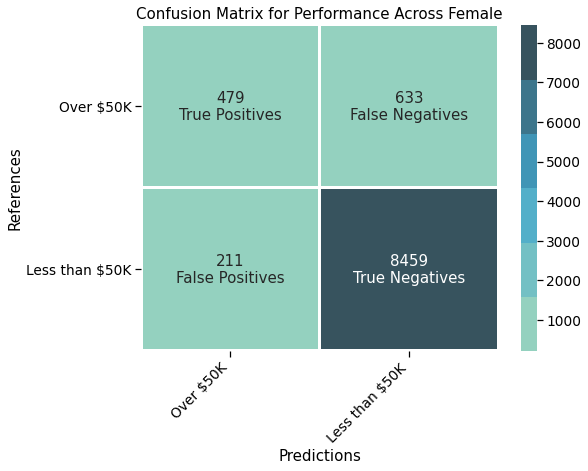

In [19]:
#@title Visualize Binary Confusion Matrix and Compute Evaluation Metrics Per Subgroup
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Female" #@param {type:"string"}

# Labels for annotating axes in plot.
classes = ['Over $50K', 'Less than $50K']

# Given define subgroup, generate predictions and obtain its corresponding 
# ground truth.
subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6], 
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df